# Importando bibliotecas

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Lendo dados

In [4]:
df = pd.read_csv('../data/processed/sample_df_processed.csv')
df['speed'] = df['speed'].astype('str')
df['feed'] = df['feed'].astype('str')

In [5]:
df.dtypes

vibration_x    float64
vibration_y    float64
vibration_z    float64
machine         object
operation       object
description     object
speed           object
feed            object
duration         int64
result           int64
dtype: object

# Separando dados em treino e teste

In [6]:
X = df.drop(columns=["result"])  
y = df["result"]

# Separando o dataset em treino e teste mantendo a proporção das classes e com uma divisão de 70% para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pre-processamento dos dados

In [7]:
# DIVISÃO ENTRE COLUNAS CATEGORICAS E NUMERICAS
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [8]:
# NORMALIZAR COLUNAS NUMERICAS
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# CODIFICAR COLUNAS CATEGORICAS
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [9]:
# PRE-PROCESSAMENTO DOS DADOS 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Criando pipeline utilizando preprocessamento dos dados e utilizando a algoritmo de regressão logistica

In [10]:
# CRIANDO O PIPELINE COM OS DADOS PRE-PROCESSADOS E O CLASSIFICADOR
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,  
        eval_metric='logloss'
    ))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

c:\Users\Leonardo\Python\PROJETOS FACULDADE\tcc_machine_learning\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:17:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Criando matriz de confusão

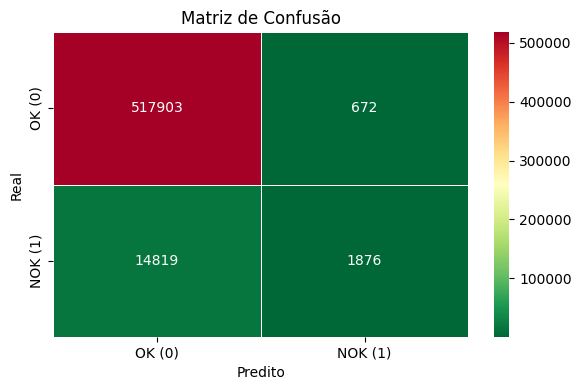

In [11]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="RdYlGn_r",
    linewidths=0.5,
    xticklabels=["OK (0)", "NOK (1)"],
    yticklabels=["OK (0)", "NOK (1)"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

1. Observa-se para classe ok mas causado pelo desbalaceamento
2. Para classe nok há uma melhora mas ainda abaixo do esperado.

## Avaliando métricas

In [12]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df.head(3)

,precision,recall,f1-score
0,0.972182,0.998704,0.985265
1,0.736264,0.112369,0.194980
accuracy,0.971059,0.971059,0.971059


Como esperando no relatório das métricas observamos:
1. A classe OK tem 97,2% das previsoes corretas. Recall de 99,9% o que mostra que a maioria dos casos ok foram detectados. Com resultados altos trazem um alto f1-score;
2. A classe NOK tem 73,6% de previsões corretas. Recall de 11,2% que mostra que o modelo ainda detecta muito pouco os casos nok. Como resultado desse equilibrio traz um f1-score baixo.
3. A acuracia é alta devido ao desbalaceamento das classes.

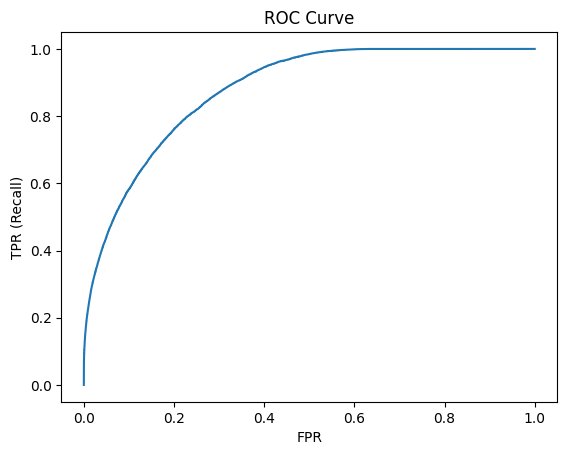

AUC: 0.88


In [13]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.show()
print(f"AUC: {auc:.2f}")



Pela curva ROC observamos:
1. Curva cresce rapidamente o que mostra boa distribuição entre as classes
2. Curva com bom resultado mas o desempenho real pelo indicadores estão abaixo
3. Encontrar a divisão adequada tende a melhorar o desempenho do modelo.

In [15]:
import numpy as np
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]

print(f"Threshold ideal (Youden): {optimal_threshold:.4f}")


Threshold ideal (Youden): 0.0294


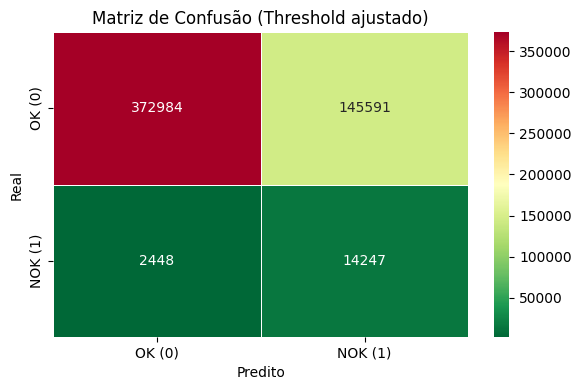

In [17]:
y_pred = (y_proba >= optimal_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="RdYlGn_r",
    linewidths=0.5,
    xticklabels=["OK (0)", "NOK (1)"],
    yticklabels=["OK (0)", "NOK (1)"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão (Threshold ajustado)")
plt.tight_layout()
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])  
report_df.head(3)

,precision,recall,f1-score
0,0.993480,0.719248,0.834410
1,0.089134,0.853369,0.161409
accuracy,0.723431,0.723431,0.723431


In [19]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_threshold_f1 = thresholds_pr[np.argmax(f1)]

print(f"Threshold ideal (F1-score máximo): {optimal_threshold_f1:.4f}")

Threshold ideal (F1-score máximo): 0.1614


In [20]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_threshold_f1 = thresholds_pr[np.argmax(f1)]


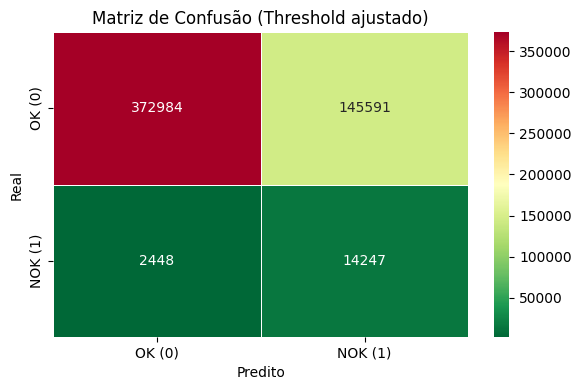

In [21]:
y_pred = (y_proba >= optimal_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="RdYlGn_r",
    linewidths=0.5,
    xticklabels=["OK (0)", "NOK (1)"],
    yticklabels=["OK (0)", "NOK (1)"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão (Threshold ajustado)")
plt.tight_layout()
plt.show()

In [22]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])  
report_df.head(3)

,precision,recall,f1-score
0,0.993480,0.719248,0.834410
1,0.089134,0.853369,0.161409
accuracy,0.723431,0.723431,0.723431


## Ajustar desbalancemaento

In [23]:
from collections import Counter

counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

In [24]:
# CRIANDO O PIPELINE COM OS DADOS PRE-PROCESSADOS E O CLASSIFICADOR
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,  
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    ))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

c:\Users\Leonardo\Python\PROJETOS FACULDADE\tcc_machine_learning\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:20:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


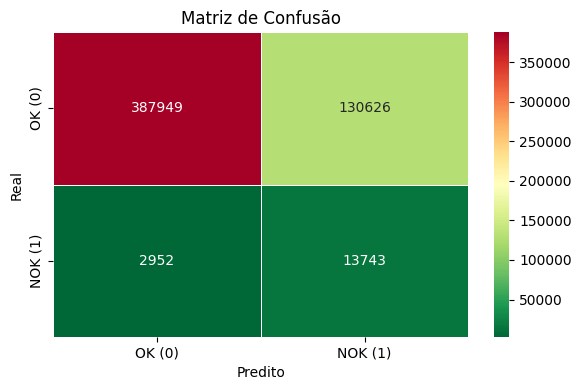

In [25]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="RdYlGn_r",
    linewidths=0.5,
    xticklabels=["OK (0)", "NOK (1)"],
    yticklabels=["OK (0)", "NOK (1)"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

In [26]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])  
report_df.head(3)

,precision,recall,f1-score
0,0.992448,0.748106,0.853126
1,0.095194,0.823181,0.170653
accuracy,0.750447,0.750447,0.750447
